# Classificació

### Libraries and loading data

In [1]:
import pandas as pd
from sklearn.svm import SVC
from skopt import BayesSearchCV
import numpy as np
np.int = int

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn.metrics import  ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../datasets/data_train_class7.csv')
df_test = pd.read_csv('../datasets/data_test_class7.csv')

In [3]:
# df_train = df_train.iloc[:, :-7]
# df_test = df_test.iloc[:, :-7]

In [4]:
df_train.head()

,BPM,Energy,Danceability,Loudness,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,is_recent,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,123,73,48,-8,11,87,140,57,17,65,1,0,0,0,0,1,0,0
1,99,21,34,-17,18,29,218,40,3,70,0,0,0,0,0,1,0,0
2,71,58,39,-7,22,38,295,47,3,63,0,1,0,0,0,0,0,0
3,135,23,40,-9,11,28,222,89,4,61,1,0,0,0,1,0,0,0
4,159,16,41,-22,12,42,199,88,3,77,0,0,1,0,0,0,0,0


In [5]:
x_train = df_train.drop(columns=['is_recent', 'Length'])
y_train = df_train['is_recent']

x_test = df_test.drop(columns=['is_recent', 'Length'])
y_test = df_test['is_recent']

clss = ['Pre-2000', 'Post-2000']

In [6]:
from sklearn.preprocessing import MinMaxScaler

data_columns = x_train.columns
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))
x_train.columns = x_test.columns = data_columns

x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
BPM,1395.0,0.456174,0.179555,0.0,0.318471,0.452229,0.557325,1.0
Energy,1395.0,0.583587,0.229908,0.0,0.401042,0.604167,0.770833,1.0
Danceability,1395.0,0.500500,0.179877,0.0,0.383721,0.500000,0.627907,1.0
Loudness,1395.0,0.723097,0.145117,0.0,0.640000,0.760000,0.840000,1.0
Liveness,1395.0,0.175110,0.169782,0.0,0.072165,0.103093,0.216495,1.0
Valence,1395.0,0.480615,0.258486,0.0,0.270833,0.458333,0.677083,1.0
Acousticness,1395.0,0.298786,0.296839,0.0,0.030612,0.183673,0.520408,1.0
Speechiness,1395.0,0.057672,0.082810,0.0,0.018868,0.037736,0.056604,1.0
Popularity,1395.0,0.542193,0.162211,0.0,0.426966,0.561798,0.674157,1.0
genre_0,1395.0,0.091039,0.287768,0.0,0.000000,0.000000,0.000000,1.0


## Models

In [7]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score


def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    # df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

In [8]:
niter = 15
cv = 10

### Naive-Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


In [10]:
gnb_model = GaussianNB().fit(x_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means = pd.DataFrame(gnb_model.theta_)
means.columns = x_train.columns
means

Priors: [0.59928315 0.40071685]
Means:



,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,0.452024,0.564132,0.497079,0.682775,0.170300,0.51008,0.317120,0.052022,0.555615,0.082536,0.488038,0.150718,0.050239,0.087321,0.105263,0.035885
1,0.462382,0.612683,0.505616,0.783399,0.182303,0.43655,0.271367,0.066122,0.522120,0.103757,0.191413,0.214669,0.150268,0.026834,0.268336,0.044723


In [11]:
print(classification_report(gnb_model.predict(x_test), y_test,target_names=clss))
results_df = save_results(gnb_model, x_test, y_test, 'GNB', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.69      0.77      0.73       318
   Post-2000       0.70      0.60      0.64       281

    accuracy                           0.69       599
   macro avg       0.69      0.69      0.69       599
weighted avg       0.69      0.69      0.69       599



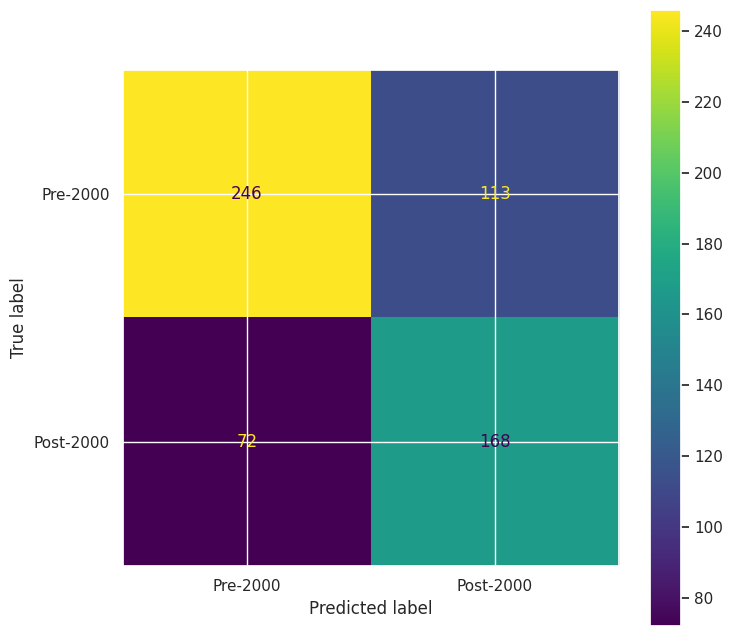

In [12]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, x_test,y_test, display_labels=clss, ax=plt.subplot());

### LDA

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.2, 0.5]
}

lda = GridSearchCV(LinearDiscriminantAnalysis(), 
                   param, 
                   cv=cv, 
                   n_jobs=-1, 
                   scoring='f1_weighted', 
                   refit=True).fit(x_train, y_train);

show_html(pd.DataFrame(lda.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.751254,1
5,"{'shrinkage': 'auto', 'solver': 'eigen'}",0.751254,1
0,"{'shrinkage': None, 'solver': 'svd'}",0.750702,3
1,"{'shrinkage': None, 'solver': 'lsqr'}",0.748323,4
7,"{'shrinkage': 0.1, 'solver': 'lsqr'}",0.731266,5


In [14]:
print(classification_report(lda.predict(x_test), y_test, target_names=clss))
results_df = save_results(lda, x_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.77      0.80       392
   Post-2000       0.62      0.71      0.66       207

    accuracy                           0.75       599
   macro avg       0.73      0.74      0.73       599
weighted avg       0.76      0.75      0.75       599



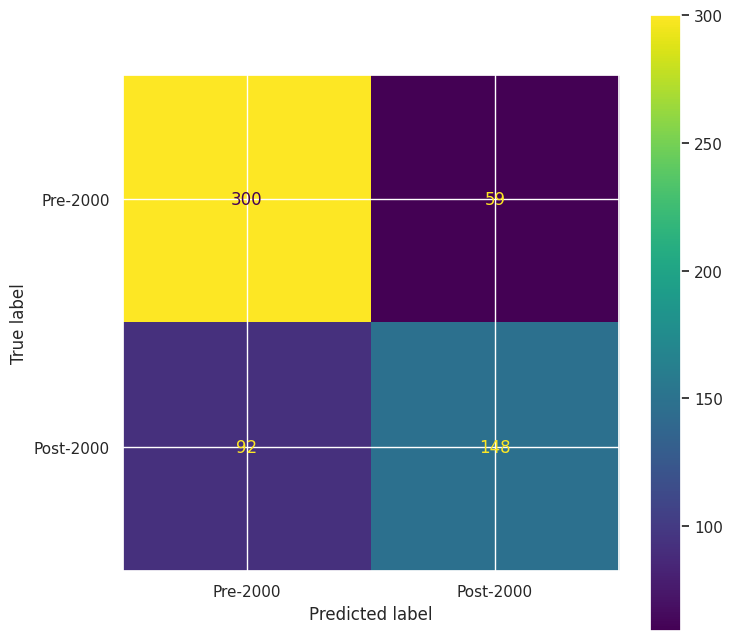

In [15]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, x_test,y_test, display_labels=clss, ax=plt.subplot());

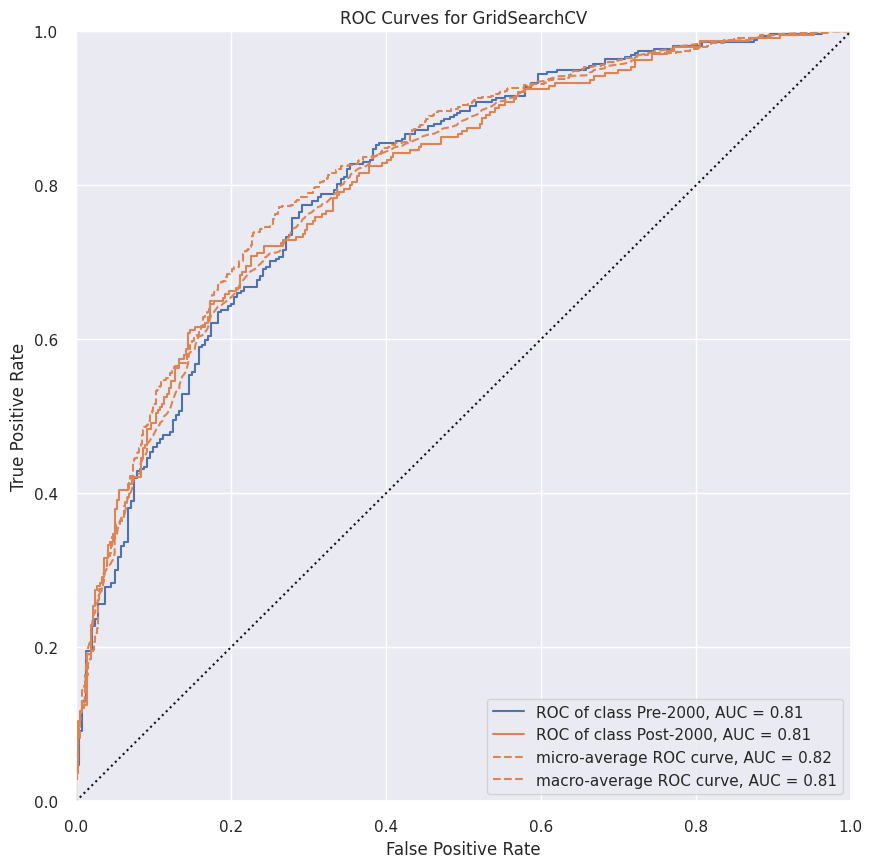

In [16]:
from yellowbrick.classifier.rocauc import roc_auc

sns.set()
plt.figure(figsize=(10, 10));
roc_auc(lda, x_train, y_train, x_test, y_test, classes=clss);

### QDA

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


param = {'reg_param':np.linspace(0,1,21, endpoint=True)}
qda =  GridSearchCV(QuadraticDiscriminantAnalysis(),
                    param,
                    cv=cv, 
                    n_jobs=-1, 
                    scoring='f1_weighted', 
                    refit=True).fit(x_train, y_train);

show_html(pd.DataFrame(qda.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ericryhr/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables ar

,params,mean_test_score,rank_test_score
0,{'reg_param': 0.0},0.703958,1
1,{'reg_param': 0.05},0.685794,2
2,{'reg_param': 0.1},0.671184,3
3,{'reg_param': 0.15000000000000002},0.662832,4
5,{'reg_param': 0.25},0.662782,5


In [18]:
print(classification_report(qda.predict(x_test), y_test, target_names=clss))
results_df = save_results(qda, x_test, y_test, 'QDA', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.71      0.77      0.74       332
   Post-2000       0.68      0.61      0.65       267

    accuracy                           0.70       599
   macro avg       0.70      0.69      0.69       599
weighted avg       0.70      0.70      0.70       599



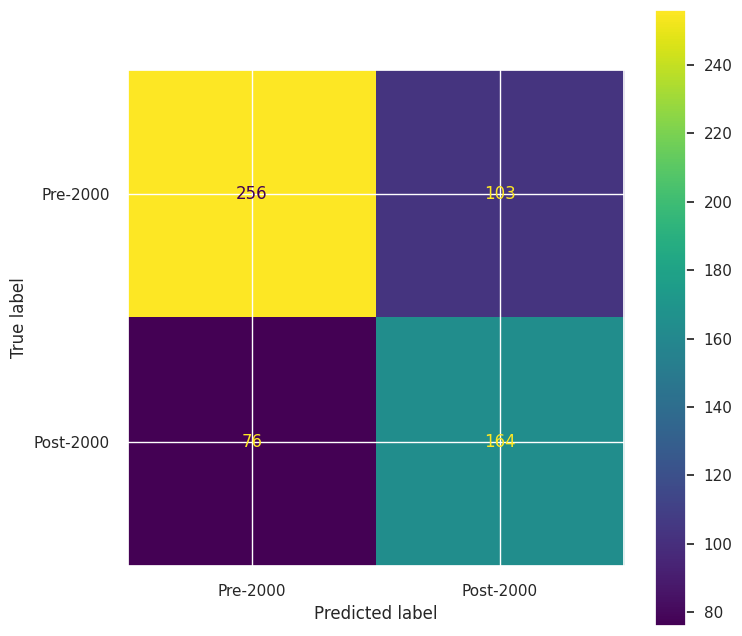

In [19]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qda, x_test,y_test, display_labels=clss, ax=plt.subplot());

### SVM lineal

In [20]:
from sklearn.model_selection import cross_val_score


param = {'C': 10**np.linspace(-3, 3, 101)}

lsvm = BayesSearchCV(SVC(kernel='linear', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_lsvm = lsvm.predict(x_test)

# r2_lsvm_train = np.mean(cross_val_score(lsvm, x_train, y_train))
# r2_lsvm_test = np.mean(cross_val_score(lsvm, x_test, y_test))

# print(f'Train R2 score: {r2_lsvm_train}')
# print(f'Test R2 score: {r2_lsvm_test}')

In [21]:
show_html(pd.DataFrame(lsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,{'C': 54.954087385762485},0.752749,1
13,{'C': 72.44359600749891},0.751983,2
5,{'C': 109.64781961431851},0.749208,3
6,{'C': 660.6934480075951},0.749082,4
14,{'C': 15.848931924611142},0.748608,5


In [22]:
print(classification_report(lsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(lsvm, x_test, y_test, 'SVM Lineal', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.82      0.76      0.79       386
   Post-2000       0.62      0.69      0.65       213

    accuracy                           0.74       599
   macro avg       0.72      0.73      0.72       599
weighted avg       0.75      0.74      0.74       599



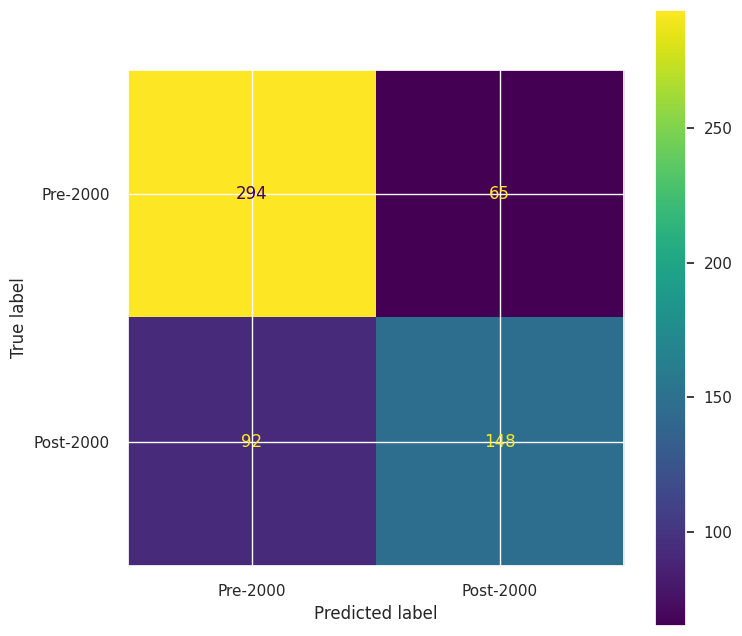

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM Polinomial

In [24]:
from sklearn.model_selection import StratifiedKFold


param = {
    'C': 10**np.linspace(-3, 3, 101),
    'degree':[2, 3]
}

# stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

qsvm = BayesSearchCV(SVC(kernel='poly', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_qsvm = qsvm.predict(x_test)
# r2_qsvm_train = np.mean(cross_val_score(qsvm, x_train, y_train))
# r2_qsvm_test = np.mean(cross_val_score(qsvm, x_test, y_test))

# print(f'Train R2 score: {r2_qsvm_train}')
# print(f'Test R2 score: {r2_qsvm_test}')

In [25]:
show_html(pd.DataFrame(qsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
0,"{'C': 1.513561248436207, 'degree': 3}",0.773386,1
12,"{'C': 5.248074602497723, 'degree': 3}",0.766628,2
7,"{'C': 1.1481536214968828, 'degree': 3}",0.766405,3
11,"{'C': 6.025595860743575, 'degree': 2}",0.765836,4
14,"{'C': 3.981071705534969, 'degree': 3}",0.762369,5


In [26]:
print(classification_report(qsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(qsvm, x_test, y_test, 'SVM Polinomic', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.85      0.76      0.80       398
   Post-2000       0.61      0.73      0.66       201

    accuracy                           0.75       599
   macro avg       0.73      0.75      0.73       599
weighted avg       0.77      0.75      0.76       599



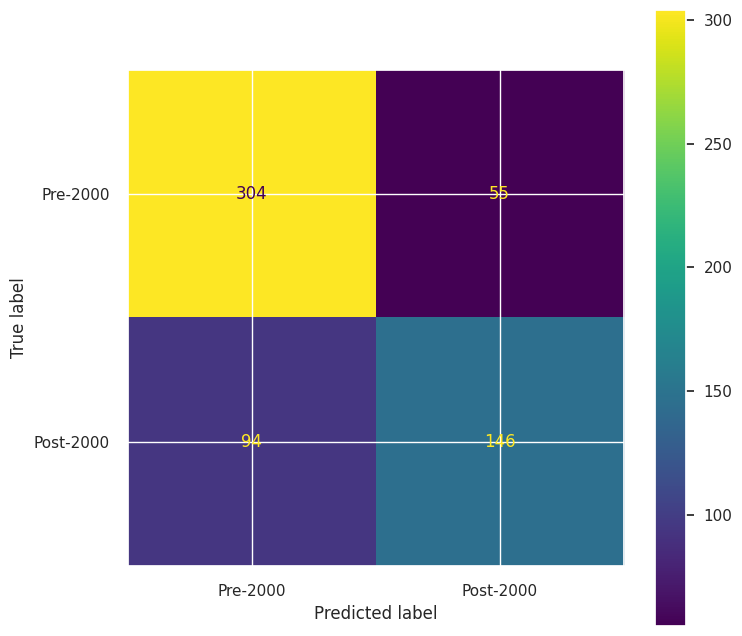

In [27]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

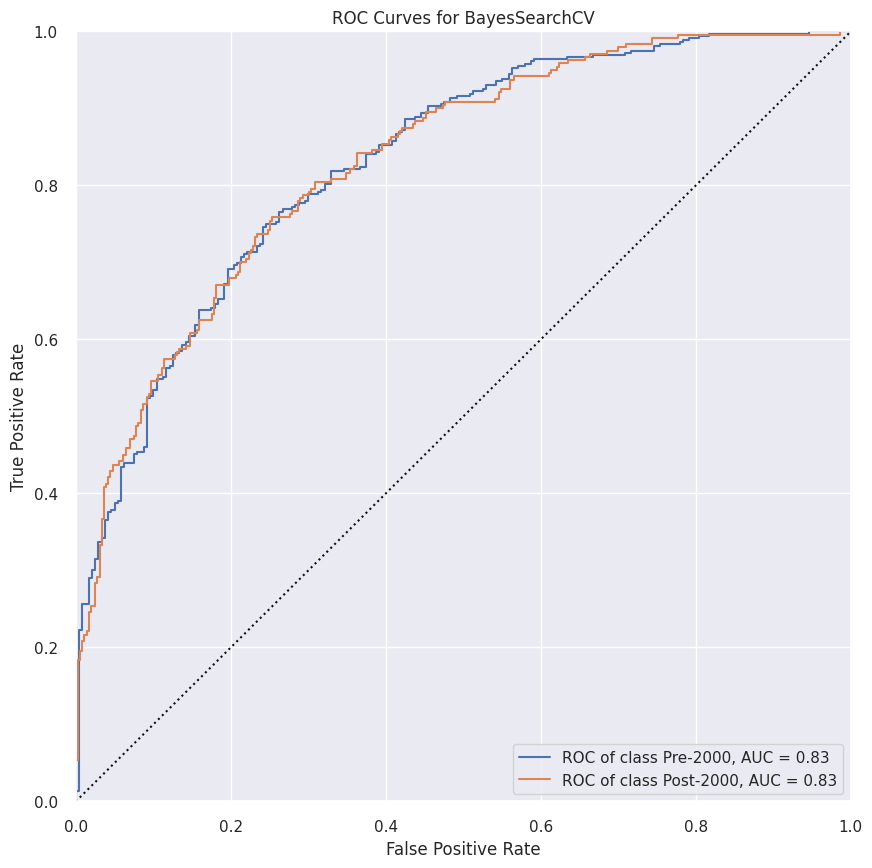

In [29]:
plt.figure(figsize=(10, 10));
roc_auc(qsvm, x_train, y_train, x_test, y_test, classes=clss, micro=False, macro=False);

### SVM RBF

In [30]:
param = {'C':10**np.linspace(-3,3,101), 
         'gamma':['scale','auto']}

rbfsvm = BayesSearchCV(SVC(kernel='rbf', random_state=0), 
                     param, 
                     n_iter=niter, 
                     cv=cv,
                     scoring='f1_weighted',
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
# y_test_predicted_rbfsvm = rbfsvm.predict(x_test)
# r2_rbfsvm_train = np.mean(cross_val_score(rbfsvm, x_train, y_train))
# r2_rbfsvm_test = np.mean(cross_val_score(rbfsvm, x_test, y_test))

# print(f'Train R2 score: {r2_rbfsvm_train}')
# print(f'Test R2 score: {r2_rbfsvm_test}')

In [31]:
show_html(pd.DataFrame(rbfsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'C': 6.918309709189363, 'gamma': 'scale'}",0.764802,1
10,"{'C': 331.13112148259074, 'gamma': 'auto'}",0.762956,2
13,"{'C': 125.89254117941663, 'gamma': 'auto'}",0.757829,3
5,"{'C': 109.64781961431851, 'gamma': 'scale'}",0.741608,4
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.739049,5


In [32]:
print(classification_report(rbfsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(rbfsvm, x_test, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.78      0.81       387
   Post-2000       0.64      0.73      0.68       212

    accuracy                           0.76       599
   macro avg       0.74      0.75      0.74       599
weighted avg       0.77      0.76      0.76       599



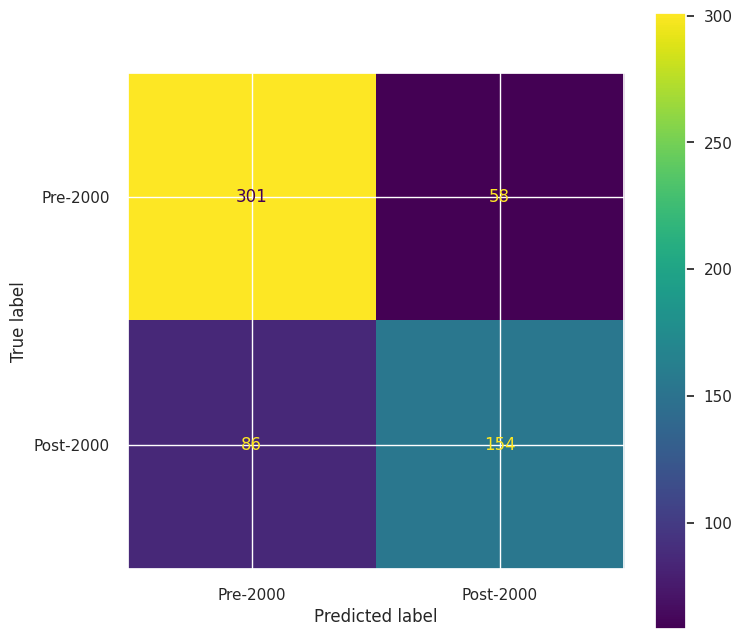

In [33]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbfsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier


param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn = BayesSearchCV(KNeighborsClassifier(), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     scoring='f1_weighted', 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
# y_test_predicted_knn = knn.predict(x_test)
# r2_knn_train = np.mean(cross_val_score(knn, x_train, y_train))
# r2_knn_test = np.mean(cross_val_score(knn, x_test, y_test))

# print(f'Train R2 score: {r2_knn_train}')
# print(f'Test R2 score: {r2_knn_test}')

In [35]:
show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'distance'}",0.718630,1
0,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'uniform'}",0.717308,2
11,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.715523,3
5,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 11, 'weights': 'distance'}",0.714827,4
7,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 11, 'weights': 'distance'}",0.710983,5


In [36]:
print(classification_report(knn.predict(x_test), y_test, target_names=clss))
results_df = save_results(knn, x_test, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.81      0.73      0.77       399
   Post-2000       0.55      0.66      0.60       200

    accuracy                           0.70       599
   macro avg       0.68      0.69      0.68       599
weighted avg       0.72      0.70      0.71       599



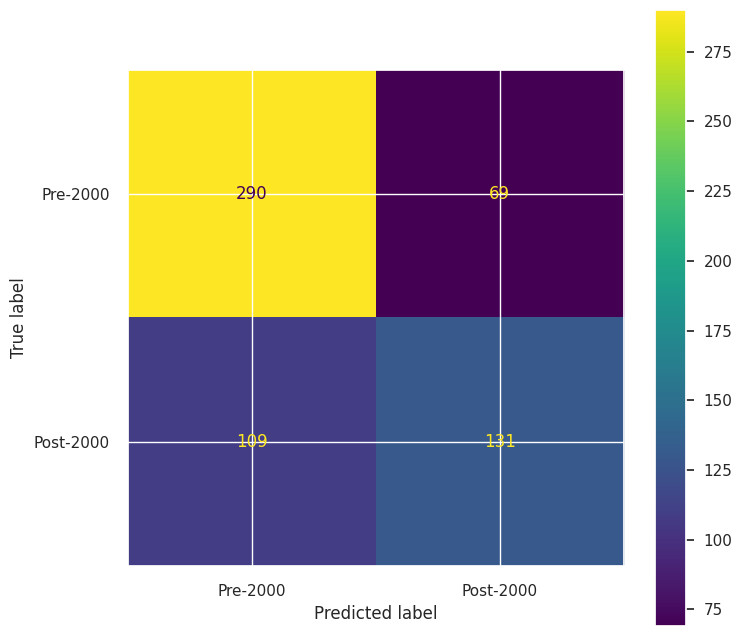

In [37]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=clss, ax=plt.subplot());

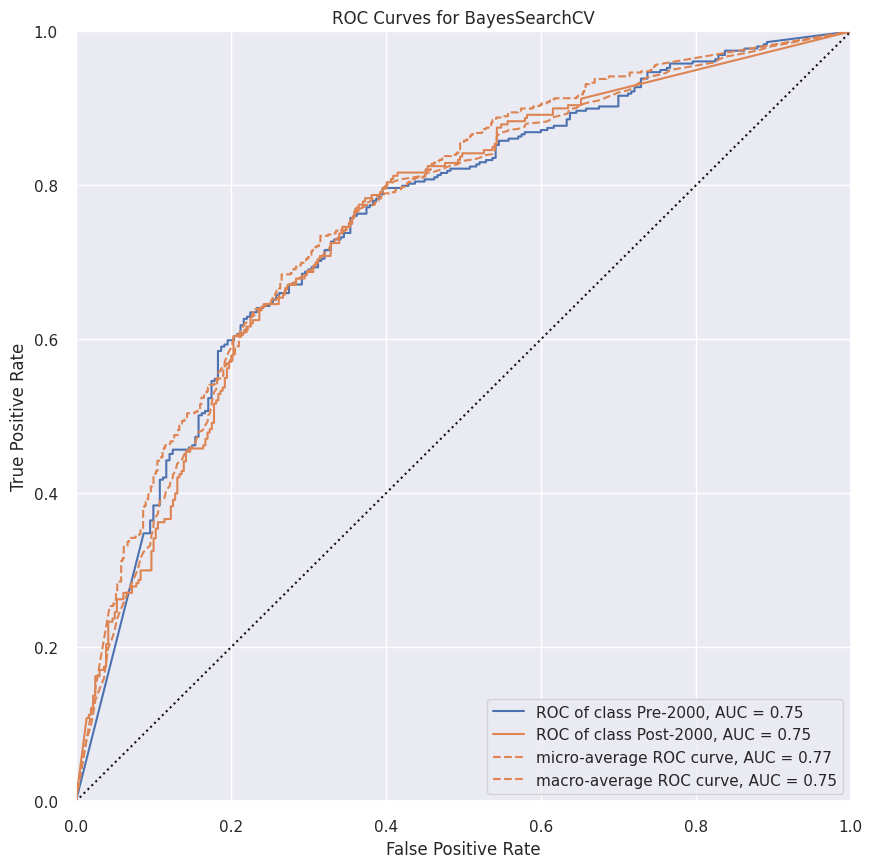

In [38]:
plt.figure(figsize=(10, 10));
roc_auc(knn, x_train, y_train, x_test, y_test, classes=clss);

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rforest = BayesSearchCV(RandomForestClassifier(), 
                        param, n_iter=niter, cv=cv, scoring='f1_weighted', n_jobs=-1, refit=True, random_state=0).fit(x_train, y_train)
# y_test_predicted_rforest = rforest.predict(x_test)
# r2_rforest_train = np.mean(cross_val_score(rforest, x_train, y_train))
# r2_rforest_test = np.mean(cross_val_score(rforest, x_test, y_test))

# print(f'Train R2 score: {r2_rforest_train}')
# print(f'Test R2 score: {r2_rforest_test}')

In [40]:
show_html(pd.DataFrame(rforest.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
8,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.758470,1
5,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 40}",0.757370,2
0,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",0.752448,3
1,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}",0.747159,4
3,"{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 40}",0.745197,5


In [41]:
print(classification_report(rforest.predict(x_test), y_test, target_names=clss))
results_df = save_results(rforest, x_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.76      0.80       396
   Post-2000       0.61      0.72      0.66       203

    accuracy                           0.75       599
   macro avg       0.72      0.74      0.73       599
weighted avg       0.76      0.75      0.75       599



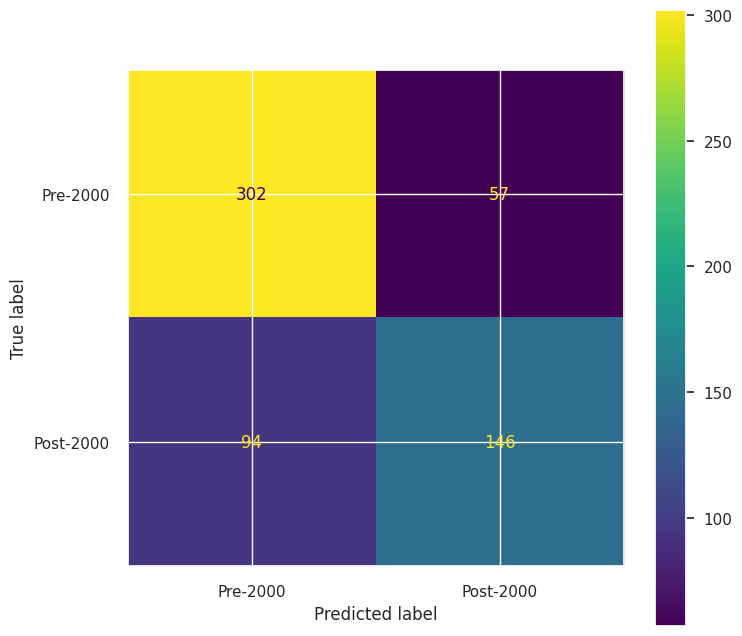

In [42]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rforest, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gboost = BayesSearchCV(GradientBoostingClassifier(random_state=0, n_iter_no_change=5), 
                        param, 
                        n_iter=15,
                        cv=cv, 
                        n_jobs=-1, 
                        refit=True, 
                        random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_gboost = gboost.predict(x_test)
# r2_gboost_train = np.mean(cross_val_score(gboost, x_train, y_train))
# r2_gboost_test = np.mean(cross_val_score(gboost, x_test, y_test))

# print(f'Train R2 score: {r2_gboost_train}')
# print(f'Test R2 score: {r2_gboost_test}')

In [44]:
show_html(pd.DataFrame(gboost.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 40}",0.757180,1
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.757055,2
14,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 40}",0.747896,3
10,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 5}",0.729026,4
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.723126,5


In [45]:
print(classification_report(gboost.predict(x_test), y_test, target_names=clss))
results_df = save_results(gboost, x_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.83      0.75      0.79       401
   Post-2000       0.57      0.70      0.63       198

    accuracy                           0.73       599
   macro avg       0.70      0.72      0.71       599
weighted avg       0.75      0.73      0.74       599



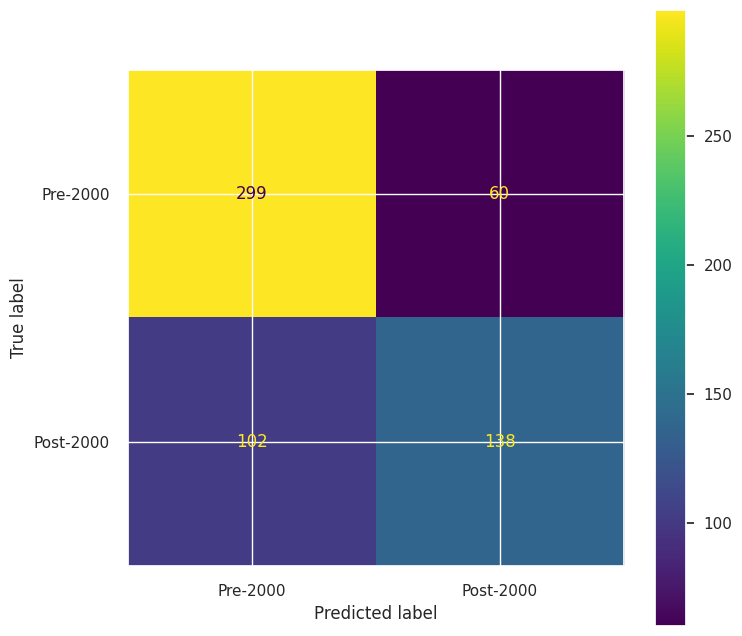

In [46]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gboost, x_test, y_test, display_labels=clss, ax=plt.subplot());

### MLP

In [47]:
from sklearn.neural_network import MLPClassifier

In [48]:
param = {'hidden_layer_sizes':[10, 50, 100, 200], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.01, 0.1]  }

mlp =  BayesSearchCV(MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0), 
                     param, n_iter=niter, cv=cv, n_jobs=-1, refit=True, scoring='f1_weighted').fit(x_train, y_train)

In [49]:
show_html(pd.DataFrame(mlp.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.748719,1
6,"{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.748719,1
12,"{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.741778,3
11,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.1}",0.740273,4
14,"{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.738220,5


In [50]:
print(classification_report(mlp.predict(x_test), y_test, target_names=clss))
results_df = save_results(mlp, x_test, y_test, 'MLP', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.79      0.79      0.79       358
   Post-2000       0.69      0.69      0.69       241

    accuracy                           0.75       599
   macro avg       0.74      0.74      0.74       599
weighted avg       0.75      0.75      0.75       599



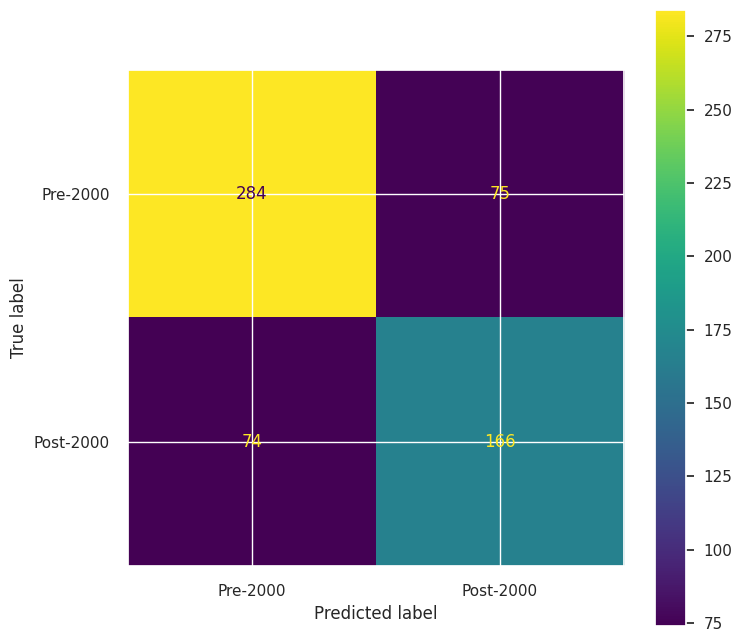

In [51]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Neural network tensorFlow

In [69]:
from tensorflow import keras


model = keras.Sequential()
model.add(keras.Input(shape=(x_train.shape[1])))
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dense(1, activation='linear', kernel_regularizer='l2'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')
model.fit(x_train, y_train, batch_size=64, epochs=150, verbose=0, validation_split=0.2)

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = f1_score(y_test, y_pred)
print(f'Test f1-score: {accuracy:.4f}')

19/19 [==============================] - 0s 4ms/step
Test f1-score: 0.6913


In [53]:
# results_df = save_results(model, x_test, y_test, 'Neural Network', results_df)

In [54]:
# plt.figure(figsize=(8,8));
# ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Combinacions de classifiers

### Stacking Classifier

In [55]:
from sklearn.ensemble import StackingClassifier


stacls = StackingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('mlp', mlp.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [56]:
print(classification_report(stacls.predict(x_test), y_test, target_names=clss))
results_df = save_results(stacls, x_test, y_test, 'Stacking (RBF + MLP)', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.78      0.81       386
   Post-2000       0.65      0.73      0.68       213

    accuracy                           0.76       599
   macro avg       0.74      0.75      0.75       599
weighted avg       0.77      0.76      0.76       599



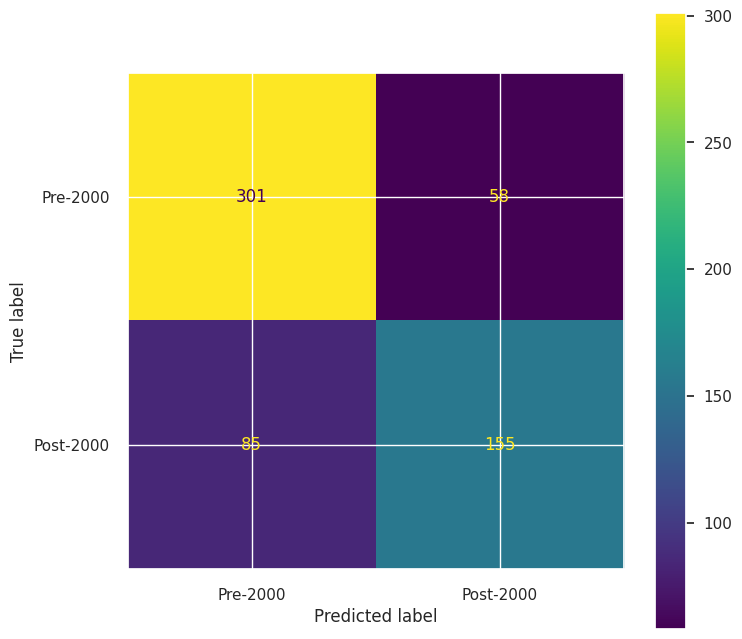

In [57]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(stacls, x_test, y_test, display_labels=clss, ax=plt.subplot());

In [58]:
stacls2 = StackingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('lda', lda.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [59]:
print(classification_report(stacls2.predict(x_test), y_test, target_names=clss))
results_df = save_results(stacls2, x_test, y_test, 'Stacking (RBF + LDA)', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.78      0.81       385
   Post-2000       0.65      0.73      0.69       214

    accuracy                           0.76       599
   macro avg       0.74      0.76      0.75       599
weighted avg       0.77      0.76      0.77       599



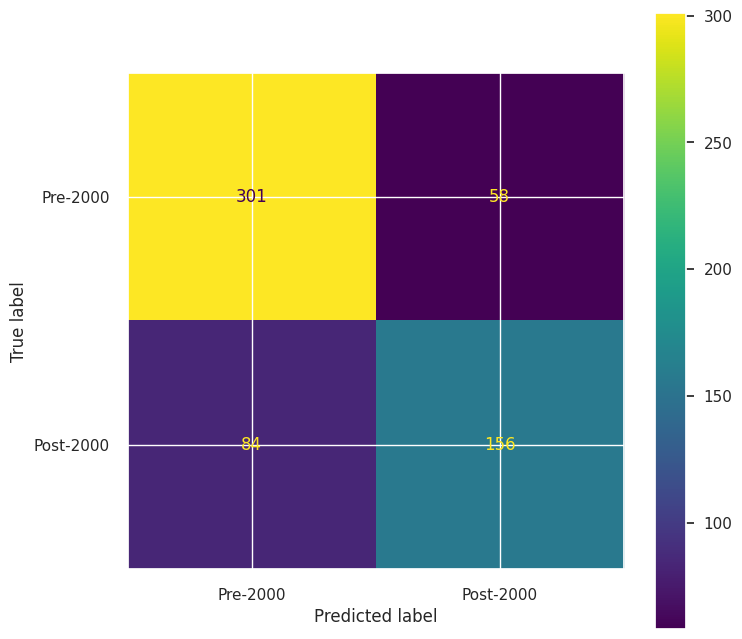

In [60]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(stacls2, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Voting Classifier

In [61]:
from sklearn.ensemble import VotingClassifier


votcls = VotingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('mlp', mlp.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [62]:
print(classification_report(votcls.predict(x_test), y_test, target_names=clss))
results_df = save_results(votcls, x_test, y_test, 'Voting (RBF + MLP)', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.86      0.77      0.81       403
   Post-2000       0.61      0.74      0.67       196

    accuracy                           0.76       599
   macro avg       0.73      0.76      0.74       599
weighted avg       0.78      0.76      0.76       599



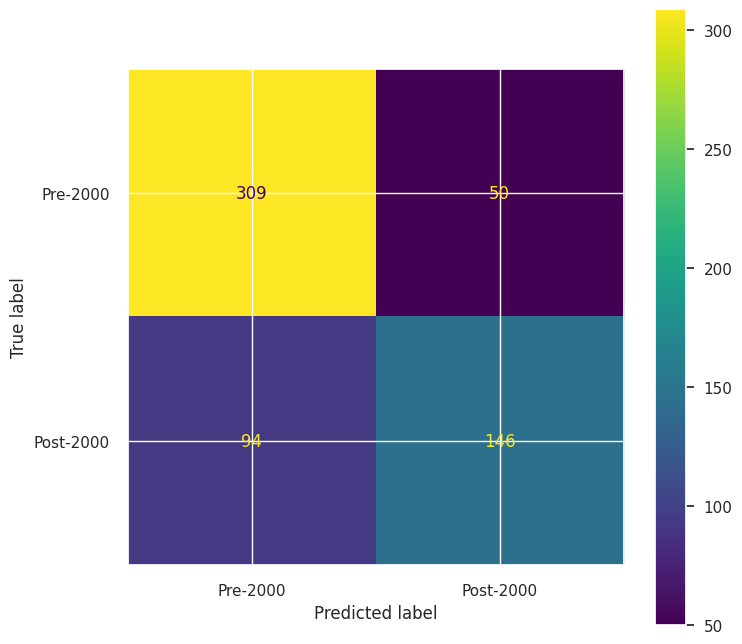

In [63]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(votcls, x_test, y_test, display_labels=clss, ax=plt.subplot());

In [64]:
votcls2 = VotingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('lda', lda.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [65]:
print(classification_report(votcls2.predict(x_test), y_test, target_names=clss))
results_df = save_results(votcls2, x_test, y_test, 'Voting (RBF + LDA)', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.88      0.75      0.81       422
   Post-2000       0.56      0.76      0.64       177

    accuracy                           0.75       599
   macro avg       0.72      0.75      0.73       599
weighted avg       0.79      0.75      0.76       599



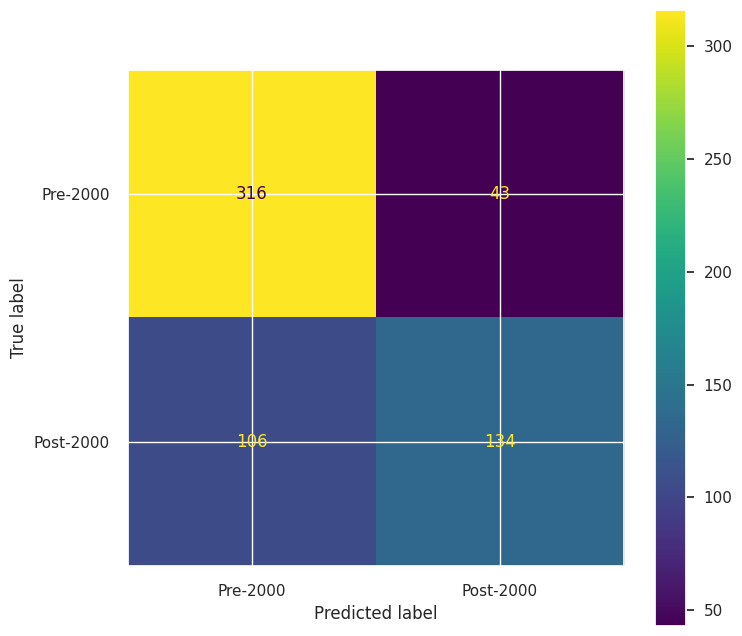

In [66]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(votcls2, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Conclusions

In [67]:
results_sorted = results_df.sort_values(by=['test f1 score (W)'], ascending=False)
results_sorted

,train XV acc,test acc,test f1 score (0),test f1 score (1),test f1 score (W)
Stacking (RBF + LDA),NaN,0.762938,0.809140,0.687225,0.748182
Stacking (RBF + MLP),NaN,0.761269,0.808054,0.684327,0.746190
SVM RBF,0.764802,0.759599,0.806971,0.681416,0.744193
MLP,0.748719,0.751252,0.792190,0.690229,0.741209
Voting (RBF + MLP),NaN,0.759599,0.811024,0.669725,0.740374
SVM Polinomic,0.773386,0.751252,0.803170,0.662132,0.732651
LDA,0.751254,0.747913,0.798935,0.662192,0.730564
Random Forest,0.758470,0.747913,0.800000,0.659142,0.729571
Voting (RBF + LDA),NaN,0.751252,0.809219,0.642686,0.725952
SVM Lineal,0.752749,0.737896,0.789262,0.653422,0.721342


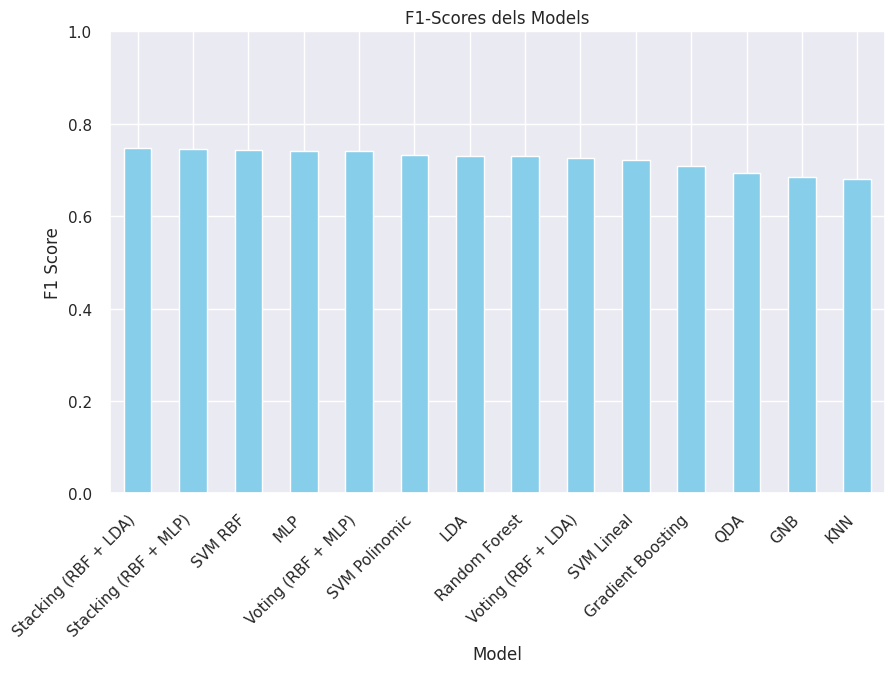

In [68]:
plt.figure(figsize=(10, 6))
results_sorted['test f1 score (W)'].plot(kind='bar', color='skyblue')
plt.title('F1-Scores dels Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.show()